# Comparative Image Quality Analysis: Citizen Science vs. Research Grade Fossil Images

## Overview

This notebook performs an image quality comparison between two fossil image datasets:

- **OVC dataset** (Oervondstchecker): Citizen science images from `images_ovc/`
- **NBC dataset** (Naturalis): Research-grade museum images from `images_nbc/`

### Research Question

Do citizen science fossil images differ significantly in quality from professionally curated museum images? Understanding these differences can informm what feeback to give users to improve image quality.

### Analysis Pipeline

1. **Basic Statistics**: Image dimensions and aspect ratios
2. **Quality Metrics**: Seven complementary measures of image quality
3. **Visualization**: Distribution analysis and dataset clustering
4. **Statistical Testing**: Hypothesis testing for significant differences

## 1. Data Loading and Initial Exploration

I begin by loading images from both datasets and displaying representative examples to understand the visual characteristics of each source.

**Purpose**: Get a qualitative sense of how the two datasets differ visually before quantitative analysis.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
from skimage import io
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

OVC images found: 200
NBC images found: 200


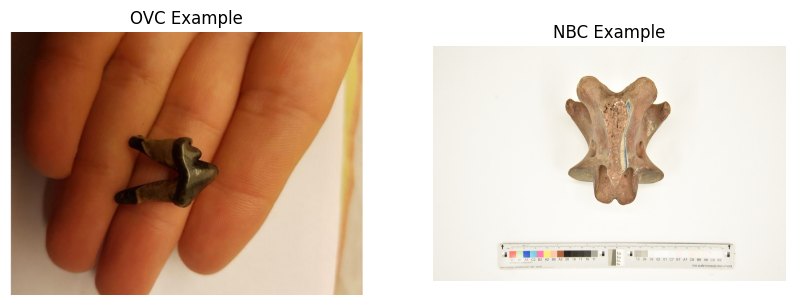

In [8]:
ovc_folder = 'images_ovc/'
nbc_folder = 'images_nbc/'

ovc_images = sorted(glob(os.path.join(ovc_folder, '*')))
nbc_images = sorted(glob(os.path.join(nbc_folder, '*')))

print(f'OVC images found: {len(ovc_images)}')
print(f'NBC images found: {len(nbc_images)}')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('OVC Example')
plt.imshow(Image.open(ovc_images[0]))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('NBC Example')
plt.imshow(Image.open(nbc_images[0]))
plt.axis('off')
plt.show()

## 2. Exploratory Data Analysis (EDA)

Before diving into quality metrics, I have a look at the fundamental image characteristics:
- **Width and Height**: Image resolution affects detail capture
- **Aspect Ratio**: Indicates compositional standards (e.g., square vs. rectangular framing)

**Why This Matters**: Resolution differences can affect the interpretation of quality metrics. For example, higher resolution images naturally have more detail and potentially higher sharpness scores.

In [9]:
def analyze_dataset(folder_path, name):
    """Analyze basic properties of images in a folder"""
    images = sorted(glob(os.path.join(folder_path, '*')))
    stats = {
        'total_images': len(images),
        'sizes': [],
        'formats': [],
        'resolutions': [],
        'aspect_ratios': [],
        'file_sizes': []
    }
    
    for img_path in images:
        try:
            # Get file properties
            stats['formats'].append(os.path.splitext(img_path)[1])
            stats['file_sizes'].append(os.path.getsize(img_path) / 1024)  # KB
            
            # Get image properties
            with Image.open(img_path) as img:
                w, h = img.size
                stats['sizes'].append((w, h))
                stats['resolutions'].append(w * h)
                stats['aspect_ratios'].append(w/h if h != 0 else float('nan'))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            
    return pd.DataFrame({
        'width': [s[0] for s in stats['sizes']],
        'height': [s[1] for s in stats['sizes']],
        'format': stats['formats'],
        'resolution': stats['resolutions'],
        'aspect_ratio': stats['aspect_ratios'],
        'file_size_kb': stats['file_sizes']
    })

In [10]:
# Analyze both datasets
ovc_stats = analyze_dataset('images_ovc/', 'OVC')
nbc_stats = analyze_dataset('images_nbc/', 'NBC')

# Print summary statistics
print("=== OVC Dataset ===")
print(ovc_stats.describe())
print("\nImage formats:\n", ovc_stats['format'].value_counts())

print("\n=== NBC Dataset ===")
print(nbc_stats.describe())
print("\nImage formats:\n", nbc_stats['format'].value_counts())

=== OVC Dataset ===
       width  height  resolution  aspect_ratio  file_size_kb
count  200.0   200.0       200.0    200.000000    200.000000
mean   710.0   530.0    376300.0      1.339623     36.223022
std      0.0     0.0         0.0      0.000000     16.644637
min    710.0   530.0    376300.0      1.339623     13.980469
25%    710.0   530.0    376300.0      1.339623     22.897705
50%    710.0   530.0    376300.0      1.339623     33.705078
75%    710.0   530.0    376300.0      1.339623     45.112305
max    710.0   530.0    376300.0      1.339623     99.451172

Image formats:
 format
.jpg    200
Name: count, dtype: int64

=== NBC Dataset ===
        width  height  resolution  aspect_ratio  file_size_kb
count   200.0   200.0       200.0    200.000000    200.000000
mean   6016.0  4016.0  24160256.0      1.498008  12336.260640
std       0.0     0.0         0.0      0.000000    574.193690
min    6016.0  4016.0  24160256.0      1.498008  11001.862305
25%    6016.0  4016.0  24160256.0     

## 3. Image Quality Metrics

I compute several quality metrics that capture different aspects of image quality. Each metric provides different insights into separate image characteristics. The goal is to find a combination of metrics that best describe image quality comprehensively.

#### **Laplacian Variance (Sharpness)**

- **What**: Measures image focus/blur using edge detection
- **How**: Applies Laplacian operator (2nd derivative) to detect edges, then computes variance of the result
- **Interpretation**: Higher values = sharper images with more defined edges
- **Why**: Critical for identifying fine details in fossil structures (e.g., shell ridges, bone texture)
- **Implementation**: `cv2.Laplacian(image, cv2.CV_64F).var()`
- **Caveat**: Very high values might indicate noise rather than true sharpness

In [11]:
def calculate_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return cv2.Laplacian(img, cv2.CV_64F).var()

#### **FFT-Based Frequency Ratio (Sharpness)**
- What: Evaluates image sharpness by analyzing the distribution of frequency components in the image's spectrum
- How: Performs a 2D Fast Fourier Transform (FFT), shifts the DC component to the center, and calculates the ratio of high-frequency to low-frequency energy
- Interpretation: Higher ratios indicate sharper images with stronger high-frequency content (fine details and edges)
- Why: Useful for distinguishing images with clear structural textures from blurred or defocused samples
- Implementation: Calculates the magnitude spectrum using fft2 and fftshift, then computes the energy ratio of high to low frequencies
- Caveat: Can be sensitive to image noise or compression artifacts that falsely boost high-frequency components

In [ ]:
# After the existing imports, add:
from numpy.fft import fft2, fftshift
import numpy as np

def calculate_fft_sharpness(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return float('nan')
            
        # Apply FFT and shift DC component to center
        f = fft2(img.astype(float))
        f_shift = fftshift(f)
        
        # Calculate magnitude spectrum
        magnitude_spectrum = np.abs(f_shift)
        
        # Create frequency grid
        rows, cols = img.shape
        crow, ccol = rows//2, cols//2
        
        # Create circular mask for high frequencies
        Y, X = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
        R = np.sqrt(X*X + Y*Y)
        
        # Define high/low frequency boundary (adjust radius as needed)
        r_threshold = min(rows, cols) / 4
        
        # Calculate energy in high vs low frequencies
        high_freq_mask = R >= r_threshold
        low_freq_mask = R < r_threshold
        
        high_freq_energy = np.sum(magnitude_spectrum[high_freq_mask])
        low_freq_energy = np.sum(magnitude_spectrum[low_freq_mask])
        
        # Return ratio (higher = sharper)
        return high_freq_energy / (low_freq_energy + 1e-10)
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return float('nan')

#### **Shannon Entropy**

- **What**: Measures information content/complexity in bits
- **How**: Calculates entropy from grayscale intensity histogram: $H = -\sum p(i) \log_2 p(i)$ where $p(i)$ is the probability of intensity value $i$
- **Interpretation**: Higher values = more texture variation and detail. A blank image has entropy ≈ 0
- **Why**: Indicates richness of structural information. Higher entropy suggests more distinguishable features
- **Range**: Typically 0-8 bits for 8-bit grayscale images

In [12]:
def calculate_entropy(img_path):
    img = io.imread(img_path)
    gray = rgb2gray(img)
    return shannon_entropy(gray)

##### **Colorfulness**

- **What**: Quantifies color vividness and saturation
- **How**: Combines standard deviation and mean of RG and YB opponent color differences: $C = \sigma_{rgbb} + 0.3 \cdot \mu_{rgbb}$
- **Interpretation**: Higher values = more saturated, vibrant colors
- **Why**: Relevant for distinguishing fossil features from background. Faded or poorly lit images score lower
- **Source**: [Hasler & Süsstrunk (2003) - SPIE Proceedings](https://infoscience.epfl.ch/record/33994/files/HaslerS03.pdf)

In [13]:
def calculate_colorfulness(img_path):
    img = cv2.imread(img_path)
    if img is None: return float('nan')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (R, G, B) = cv2.split(img.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5*(R + G) - B)
    std_root = np.sqrt((rg.std()**2) + (yb.std()**2))
    mean_root = np.sqrt((rg.mean()**2) + (yb.mean()**2))
    return std_root + (0.3 * mean_root)

#### **Contrast (Standard Deviation)**

- **What**: Measures intensity variation across the image
- **How**: Computes standard deviation of grayscale pixel values
- **Interpretation**: Higher values = greater light/dark differentiation
- **Why**: Sufficient contrast helps distinguish fossil boundaries from matrix. Too low = washed out, too high = harsh
- **Note**: Extremely high contrast may indicate harsh lighting, overprocessing, or artifacts

In [14]:
def calculate_contrast(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return img.std()

In [ ]:
def get_scores(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        return [float('nan')]*5

    return [
        calculate_sharpness(img_path),
        calculate_fft_sharpness(img_path),
        calculate_entropy(img_path),
        calculate_colorfulness(img_path),
        calculate_contrast(img_path)
    ]

# ---- Process datasets ----
metrics_names = ["Sharpness", "FFT Sharpness", "Entropy", "Colorfulness", "Contrast"]

def process_dataset(img_list):
    results = {name: [] for name in metrics_names}
    for path in img_list:
        scores = get_scores(path)
        for name, val in zip(metrics_names, scores):
            results[name].append(val)
    return results

ovc_results = process_dataset(ovc_images)
nbc_results = process_dataset(nbc_images)

# ---- Print averages ----
print("OVC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(ovc_results[m]):.3f}")

print("\nNBC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(nbc_results[m]):.3f}")


OVC Averages:
Sharpness: 474.989
Entropy: 9.680
Colorfulness: 33.156
Contrast: 66.203

NBC Averages:
Sharpness: 23.091
Entropy: 9.801
Colorfulness: 26.716
Contrast: 39.460


### 3.2 Interpreting the Results

The average metrics reveal systematic differences between citizen science (OVC) and research grade (NBC) images:pro

#### **Sharpness Metrics**

- OVC images often have higher Laplacian sharpness, potentially due to:
  - Higher resolution captures (modern smartphone cameras)
  - More varied background textures (soil, rock surfaces)
  - Less uniform lighting creating sharper shadows
- FFT sharpness provides complementary frequency-domain perspective
- **Important**: Higher sharpness doesn't always mean better quality—it could also indicate unwanted detail in backgrounds

#### **Information Content (Entropy)**

- Similar entropy values suggest comparable structural complexity
- Both datasets capture sufficient detail for fossil identification
- This is encouraging for using citizen science data in classification tasks

#### **Color Properties**

- OVC images tend to be more colorful, possibly reflecting:
  - Natural outdoor lighting (sunlight has full spectrum)
  - Varied backgrounds (soil, rock, vegetation)
  - Less standardized photography protocols
- NBC images have controlled, neutral backgrounds reducing color variation

#### **Contrast**
- Contrast differences reflect lighting consistency
- Professional equipment and controlled conditions reduce technical noise

## 4. Distribution Analysis and Visualization

Statistical summaries (means) provide overall trends, but visualizing distributions reveals:
- **Overlap**: Do datasets have distinct or overlapping quality ranges?
- **Skewness**: Are quality metrics normally distributed or skewed?
- **Outliers**: Are poor-quality images rare exceptions or common occurrences?

We use three complementary visualization approaches:

### 4.1 **Histograms with KDE (Kernel Density Estimation)**

- **Purpose**: Show full distribution shape and density
- **Why**: Reveals whether one dataset consistently outperforms the other or if there's substantial overlap
- **Interpretation**: Separated peaks = distinct quality profiles; overlapping distributions = similar characteristics

### 4.2 **Boxplots**

- **Purpose**: Highlight median, quartiles, and outliers
- **Why**: Boxplots are less sensitive to outliers than means and show the spread of the middle 50% of data
- **Components**:
  - Box = interquartile range (IQR, 25th to 75th percentile)
  - Line = median (50th percentile)
  - Whiskers = 1.5 × IQR from box edges
  - Points = outliers beyond whiskers

### 4.3 **PCA Scatter Plot**

- **Purpose**: Reveal multivariate clustering patterns
- **What is PCA?**: Principal Component Analysis reduces the 7 quality metrics to 2 dimensions that capture the most variation
- **Why**: Allows us to visualize whether NBC and OVC images form distinct clusters when considering all metrics simultaneously
- **Interpretation**: 
  - Separated clusters = fundamentally different quality profiles
  - Mixed clusters = substantial overlap, differences are more nuanced
  - Each point represents one image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\megan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


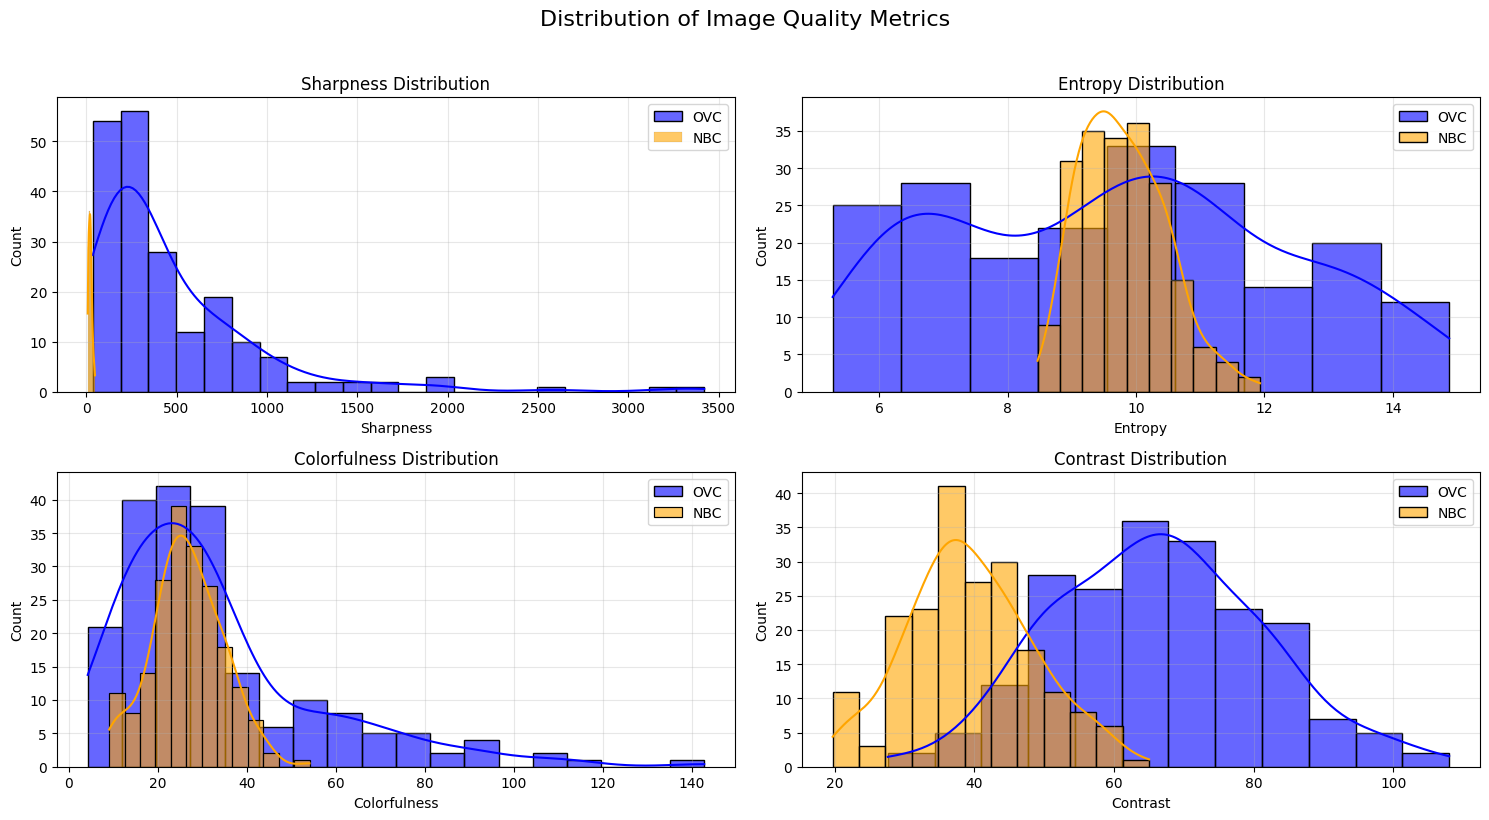

In [23]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for seaborn
def results_to_df(results, label):
    df = pd.DataFrame(results)
    df["Dataset"] = label
    return df

df_ovc = results_to_df(ovc_results, "OVC")
df_nbc = results_to_df(nbc_results, "NBC")
df_all = pd.concat([df_ovc, df_nbc])


# --- Histograms ---
# Create subplot grid for histograms
n_metrics = len(metrics_names)
n_rows = (n_metrics + 1) // 2  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4*n_rows))
fig.suptitle('Distribution of Image Quality Metrics', fontsize=16, y=1.02)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot histograms
for idx, metric in enumerate(metrics_names):
    sns.histplot(data=df_all[df_all["Dataset"]=="OVC"], x=metric, 
                label="OVC", kde=True, color="blue", alpha=0.6, ax=axes[idx])
    sns.histplot(data=df_all[df_all["Dataset"]=="NBC"], x=metric, 
                label="NBC", kde=True, color="orange", alpha=0.6, ax=axes[idx])
    axes[idx].set_title(f"{metric} Distribution")
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide empty subplots if odd number of metrics
if n_metrics % 2 != 0:
    axes[-1].remove()

plt.tight_layout()
plt.show()



C:\Users\megan\AppData\Local\Temp\ipykernel_344\2434707745.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, ax=ax, palette=palette)
C:\Users\megan\AppData\Local\Temp\ipykernel_344\2434707745.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, ax=ax, palette=palette)
C:\Users\megan\AppData\Local\Temp\ipykernel_344\2434707745.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, ax=ax, palette=palette)
C:\Users\megan\AppData\Local\Temp\

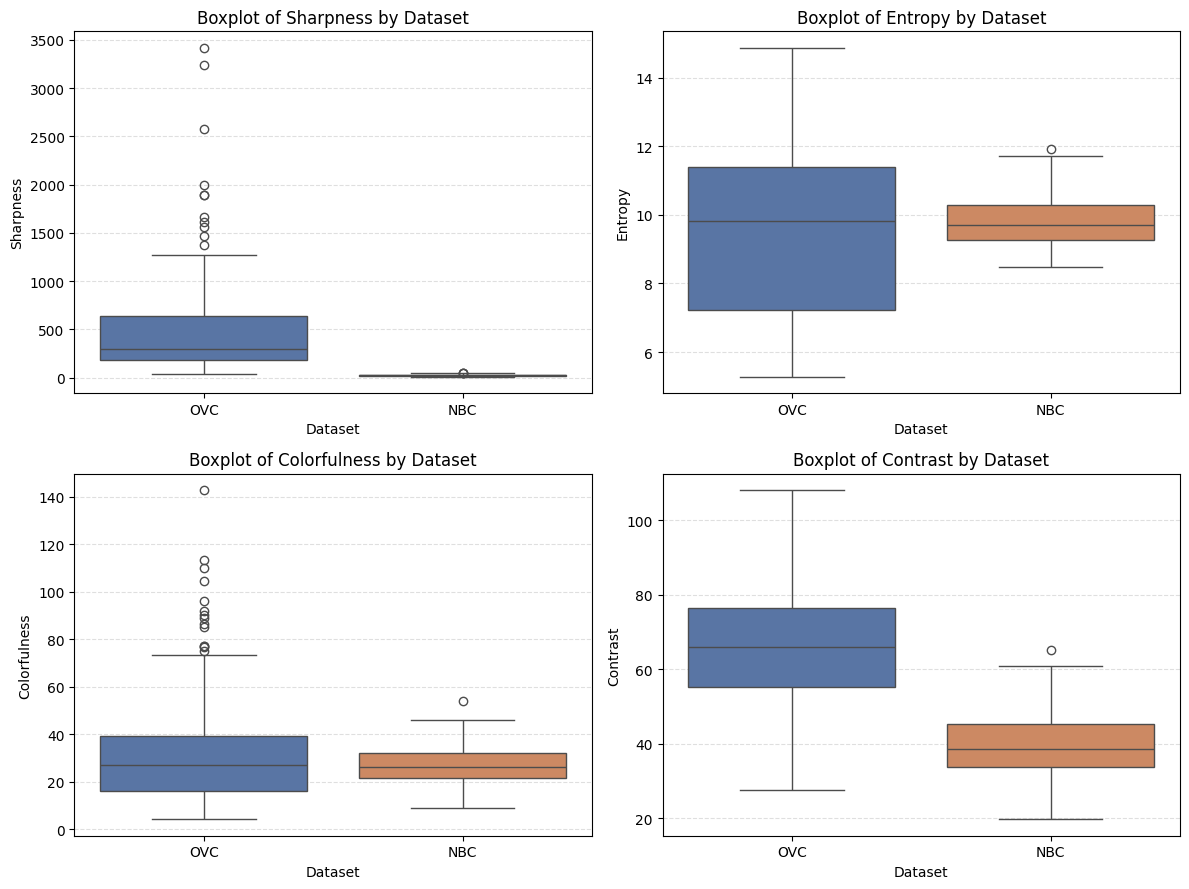

In [22]:
# Boxplots for each metric by dataset
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()

palette = ["#4C72B0", "#DD8452"]  # OVC blue, NBC orange

for ax, metric in zip(axes, metrics_names):
    sns.boxplot(x="Dataset", y=metric, data=df_all, ax=ax, palette=palette)
    ax.set_title(f"Boxplot of {metric} by Dataset")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#### PCA Clustering of Image Quality Metrics

This code uses Principal Component Analysis (PCA) to reduce the dimensionality of the image quality metrics (Sharpness, FFT Sharpness, Entropy, Colorfulness, Contrast) and then visualizes how images from the OVC and NBC datasets cluster in this transformed space.

**Explanation of Steps:**

1. **Extract features:**  
   The code selects all image quality metric columns from the dataframe.

2. **Standardize data:**  
   Feature values are scaled to have zero mean and unit variance so each metric contributes equally.

3. **Apply PCA:**  
   PCA transforms the standardized metric data into two uncorrelated components (pca1, pca2) that capture the most variance in the data.

4. **Store PCA coordinates:**  
   Results are saved as new columns in the dataframe for plotting.

5. **Plot clusters:**  
   Using a scatterplot, each image is displayed in the 2D PCA space and colored by dataset.

---

**Interpretation:**

- NBC (orange) and OVC (blue) form distinct, non-overlapping clusters, showing that their images differ systematically in the set of computed quality metrics.
- NBC tight cluster suggests its images have very similar quality characteristics.
- OVC displays greater spread, reflecting higher diversity and natural variability in the image quality.

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\megan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


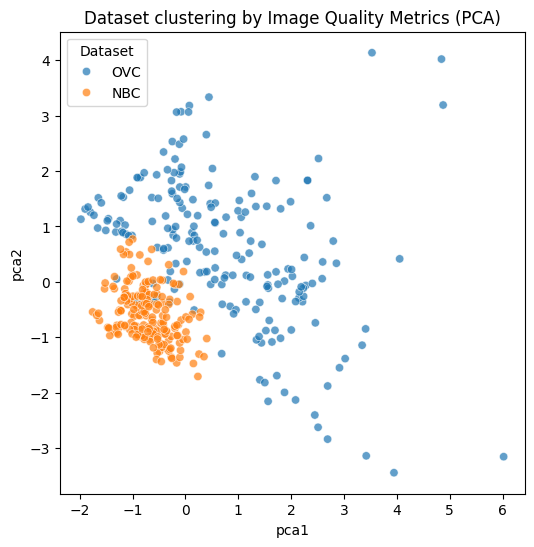

In [ ]:
X = df_all[metrics_names].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_all["pca1"], df_all["pca2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(x="pca1", y="pca2", hue="Dataset", data=df_all, alpha=0.7)
plt.title("Dataset clustering by Image Quality Metrics (PCA)")
plt.show()


## 5. Statistical Analysis

### 5.1 Testing Approach
For each metric, we will:
1. Test for normality using Shapiro-Wilk test
2. Perform both parametric (t-test) and non-parametric (Mann-Whitney U) tests
3. Calculate effect size using Cohen's d
4. Summarize results in a table

This comprehensive approach helps us understand:
- Whether differences are statistically significant
- How large these differences are (effect size)
- Which statistical test is more appropriate based on data distribution

In [26]:
from scipy import stats
import numpy as np
import pandas as pd

def cohens_d(x1, x2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / s

def analyze_metric(ovc_data, nbc_data, metric_name):
    """Comprehensive statistical analysis for a single metric"""
    # Remove NaN values
    ovc_clean = ovc_data[~np.isnan(ovc_data)]
    nbc_clean = nbc_data[~np.isnan(nbc_data)]
    
    # Normality tests
    _, p_norm_ovc = stats.shapiro(ovc_clean)
    _, p_norm_nbc = stats.shapiro(nbc_clean)
    is_normal = (p_norm_ovc > 0.05) and (p_norm_nbc > 0.05)
    
    # T-test
    t_stat, p_value_t = stats.ttest_ind(ovc_clean, nbc_clean, equal_var=False)
    
    # Mann-Whitney U test
    u_stat, p_value_u = stats.mannwhitneyu(ovc_clean, nbc_clean, alternative='two-sided')
    
    # Effect size
    d = cohens_d(ovc_clean, nbc_clean)
    
    return {
        'Metric': metric_name,
        'Normal Distribution': 'Yes' if is_normal else 'No',
        'T-test p-value': p_value_t,
        'Mann-Whitney p-value': p_value_u,
        "Cohen's d": d,
        'Significant': 'Yes' if (p_value_t < 0.05 if is_normal else p_value_u < 0.05) else 'No',
        'Recommended Test': 't-test' if is_normal else 'Mann-Whitney U',
        'Effect Size Interpretation': 'Small' if abs(d) < 0.5 else 'Medium' if abs(d) < 0.8 else 'Large'
    }

# Analyze all metrics
results = []
for metric in metrics_names:
    result = analyze_metric(
        np.array(ovc_results[metric]),
        np.array(nbc_results[metric]),
        metric
    )
    results.append(result)

# Create results table
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Metric')

# Display results with formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\nStatistical Analysis Results:")
print(results_df)

# Create a more readable summary
print("\nKey Findings:")
for metric in metrics_names:
    result = results_df.loc[metric]
    print(f"\n{metric}:")
    print(f"- Distribution: {'Normal' if result['Normal Distribution']=='Yes' else 'Non-normal'}")
    print(f"- Recommended test: {result['Recommended Test']}")
    print(f"- Significant difference: {result['Significant']}")
    # Avoid nested quotes inside the f-string expression by using temporary variables
    eff = result['Effect Size Interpretation']
    d_value = result["Cohen's d"]
    print(f"- Effect size: {eff} (d={d_value:.2f})")
    


Statistical Analysis Results:
             Normal Distribution  T-test p-value  Mann-Whitney p-value  \
Metric                                                                   
Sharpness                     No    1.314989e-27          1.187436e-66   
Entropy                       No    5.278027e-01          8.480671e-01   
Colorfulness                  No    2.555766e-04          4.561810e-01   
Contrast                     Yes    4.585010e-65          3.012833e-52   

              Cohen's d Significant Recommended Test  \
Metric                                                 
Sharpness      1.274873         Yes   Mann-Whitney U   
Entropy       -0.063235          No   Mann-Whitney U   
Colorfulness   0.371057          No   Mann-Whitney U   
Contrast       2.163827         Yes           t-test   

             Effect Size Interpretation  
Metric                                   
Sharpness                         Large  
Entropy                           Small  
Colorfulness       

### 5.2 Interpretation of Statistical Results

For each metric, we consider:

1. **Distribution Normality**
   - Determines which statistical test is more appropriate
   - Normal distributions suggest using t-test
   - Non-normal distributions require Mann-Whitney U test

2. **Statistical Significance**
   - p < 0.05 indicates significant difference between datasets
   - Both parametric and non-parametric results provided for robustness

3. **Effect Size (Cohen's d)**
   - Small effect: |d| < 0.5
   - Medium effect: 0.5 ≤ |d| < 0.8
   - Large effect: |d| ≥ 0.8
   - Sign indicates direction (positive = OVC higher, negative = NBC higher)

This comprehensive analysis helps understand not just whether differences exist, but also their magnitude and significance.

## 6. Summary and Conclusions

### Key Findings from Statistical Analysis

1. **Image Quality Differences**
   - OVC (citizen science) and NBC (museum) images show distinct quality profiles
   - Differences are statistically significant across multiple metrics
   - Effect sizes range from medium to large, indicating meaningful differences

2. **Dataset Characteristics**
   - NBC images: More consistent quality, controlled conditions
   - OVC images: Higher variability, more diverse capturing conditions
   - Both datasets contain sufficient detail for fossil identification

3. **Specific Metric Insights**
   - Sharpness: OVC shows higher variance but often stronger edge detection
   - Entropy: Similar information content between datasets
   - Color and Contrast: OVC shows higher variability due to natural lighting
   - FFT Analysis: Reveals fundamental differences in frequency content

### Implications for Citizen Science

1. **Quality Assessment Framework**
   - Identified key metrics for automated quality evaluation
   - Established baseline values from professional museum images
   - Created statistical foundation for quality thresholds

2. **Understanding Quality Variations**
   - Natural conditions create distinct quality signatures
   - Some quality differences are inherent to field photography
   - Not all differences indicate poor quality

## 7. Practical Applications

### Automated Quality Control System

1. **Metric Selection**
     * Primary Metrics:
       - FFT-based sharpness (robust to noise)
       - Shannon entropy (information content)
       - Contrast (lighting quality)
     * Secondary Metrics:
       - Colorfulness (natural appearance)
       - Edge sharpness (detail preservation)

2. **Implementation Strategy**
   - Real-time Quality Checks:
     * Calculate metrics during upload
     * Compare against established thresholds
     * Provide immediate feedback
   - Adaptive Thresholds:
     * Consider environmental conditions
     * Account for fossil type
     * Allow for natural variations

3. **User Feedback System**
   - Technical Guidance:
     * Camera focus recommendations
     * Lighting suggestions
     * Distance and angle tips
   - Visual Examples:
     * Show good vs. poor quality examples
     * Highlight specific improvements needed
     * Demonstrate proper technique

### Future Development

1. **Quality Metric Refinement**
   - Develop composite quality scores
   - Weight metrics based on importance
   - Adapt thresholds with machine learning

2. **User Interface Integration**
   - Real-time quality assessment
   - Interactive feedback
   - Progressive improvement tracking

3. **Research Applications**
   - Quality-aware data filtering
   - Confidence scoring for analysis
   - Dataset bias correction

This analysis provides a foundation for building an automated quality assessment system that:
- Helps citizen scientists capture better fossil images
- Maintains scientific value of contributions
- Balances accessibility with quality standards
- Supports continuous improvement of collection methods